/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Best Hyperparameters - Hidden Units: (256, 128), Learning Rate: 0.001, Regularizer: 1e-05
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1449
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0910 
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0913 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0535 
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0057 
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0134 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9765 
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9630 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9521 
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9288 
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9010 
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9023 
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8856 
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

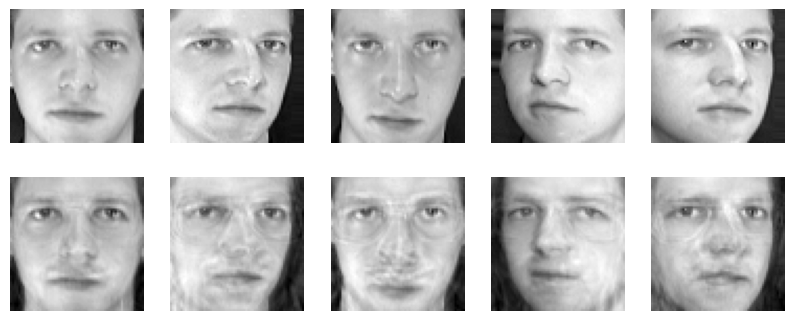

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_olivetti_faces
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

# Load and preprocess the Olivetti faces dataset
data = fetch_olivetti_faces()
X = data.data

# Step 1: Standardize and apply PCA to preserve 99% variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.99, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

# Define function to create the autoencoder model with Leaky ReLU activation and MAE loss
def create_autoencoder(hidden_units, learning_rate, regularizer):
    model = Sequential([
        layers.Input(shape=(X_pca.shape[1],)),
        layers.Dense(hidden_units[0], activation=layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dense(hidden_units[1], activation=layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dense(hidden_units[0], activation=layers.LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(regularizer)),
        layers.Dense(X_pca.shape[1], activation='linear')  # Linear activation for output layer
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanAbsoluteError())
    return model

# Step 3: K-fold cross-validation to tune learning rate and regularizer
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
hidden_units_options = [(128, 64), (256, 128)]
learning_rates = [0.001, 0.0005]
regularizers_ = [1e-4, 1e-5]
best_model = None
lowest_loss = float('inf')

for hidden_units in hidden_units_options:
    for lr in learning_rates:
        for reg in regularizers_:
            fold_losses = []
            for train_index, val_index in kfold.split(X_pca):
                X_train, X_val = X_pca[train_index], X_pca[val_index]
                model = create_autoencoder(hidden_units, lr, reg)
                history = model.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_val, X_val), verbose=0)
                fold_losses.append(history.history['val_loss'][-1])

            avg_loss = np.mean(fold_losses)
            if avg_loss < lowest_loss:
                lowest_loss = avg_loss
                best_model = model
                best_params = (hidden_units, lr, reg)

print(f"Best Hyperparameters - Hidden Units: {best_params[0]}, Learning Rate: {best_params[1]}, Regularizer: {best_params[2]}")

# Step 4: Train best model on full training data
best_model.fit(X_pca, X_pca, epochs=50, batch_size=32, verbose=1)

# Step 5: Evaluate and display original and reconstructed images
X_test_reconstructed = best_model.predict(X_pca)

# Display a few original and reconstructed images
def display_images(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(64, 64), cmap="gray")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(64, 64), cmap="gray")
        plt.axis("off")

display_images(X, scaler.inverse_transform(pca.inverse_transform(X_test_reconstructed)))
